# Age Regression with Tensorflow Probability

In this notebook you will learn how work with TFP. You will set up regression models that are able to output a gaussian conditional probability distribution. You will define different models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You will model the conditional probability distribution as a Normal distribution with a constant and flexible standart deviation $\sigma$. The mean $\mu$ of the CPD will depend non-linearly on the input. You will compare the NLL of the two models with the constant and felxible standart deviation $\sigma$. As input data you will use images of faces and you will try to predict the conditional probability distribution of their age.

**Dataset:** 
You work with a the UTKFace dataset. It is a large dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The data is already preprcessed and rescaled (80x80 pixels) so you can work with it. You will only use the information of the age.

**Content:**
* Load and and split the dataset 
* Fit a model with keras and TFP that models the CPD with a non-linear mean $\mu$ and a constant standart deviation $\sigma$ .
* Fit a model with keras and TFP that models the CPD with a non-linear mean $\mu$ and a flexible standart deviation $\sigma$ with TFP.
* Compare the two models based on the NLL loss on the test dataset.


In [0]:
!pip install tensorflow==2.1.0

In [0]:
!pip install tensorflow_probability==0.8.0

#### Imports

In [0]:
import numpy as np
import urllib
import os
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers
tfd = tfp.distributions


In [0]:
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.8.0
TF  Version 2.1.0


#### Loading the data, if it is not loaded

In [0]:
if not os.path.isfile('X_faces.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/5m7nmebpjysqtus/X_faces.npy?dl=1",
    "X_faces.npy")

if not os.path.isfile('Y_age.npy'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/flpyvgdqoatdw0g/Y_age.npy?dl=1",
    "Y_age.npy")


In [0]:
X=np.load("X_faces.npy")
Y=np.load("Y_age.npy")

#### Splitting the data into train, val and test dataset

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=201)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=34)

In [0]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10642, 80, 80, 3)
(5242, 80, 80, 3)
(7824, 80, 80, 3)


#### Looking at the image data

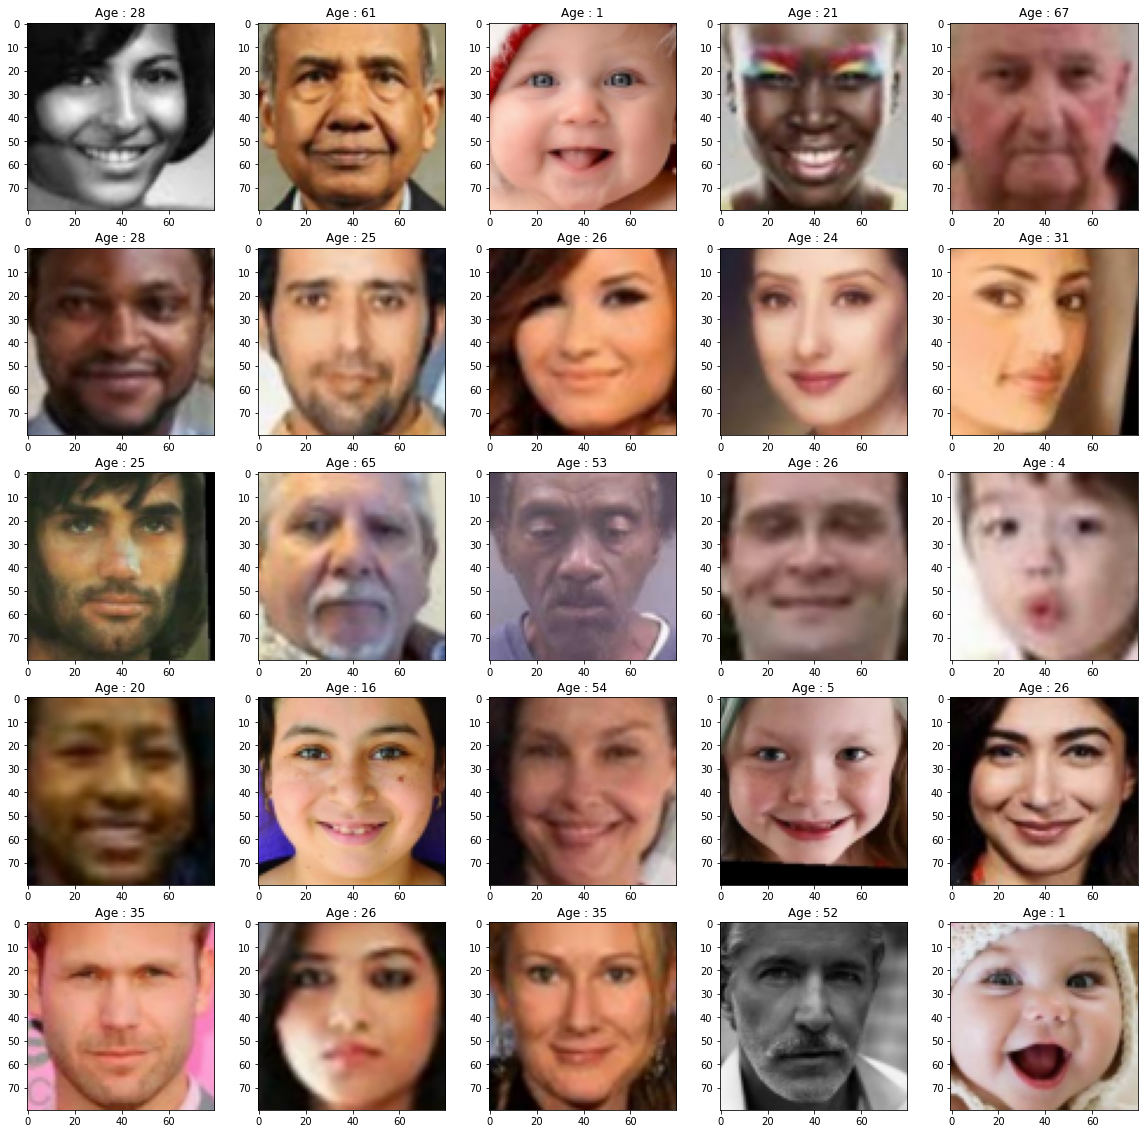

In [0]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i])
    plt.title("Age : "+ np.str(y_train[i]))

#### Normalize the data

In [0]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255

In [0]:
X_train = np.array(X_train,dtype="float32")
X_val = np.array(X_val,dtype="float32")
X_test = np.array(X_test,dtype="float32")

y_train = np.array(y_train,dtype="float32")
y_val = np.array(y_val,dtype="float32")
y_test = np.array(y_test,dtype="float32")

#### Looking at the distribution of the target variable

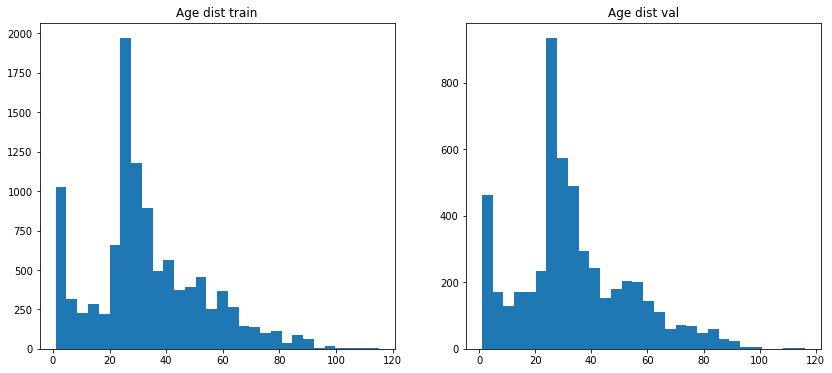

In [0]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(y_train,bins=30)
plt.title("Age dist train")
plt.subplot(1,2,2)
plt.hist(y_val,bins=30)
plt.title("Age dist val")
plt.show()


## Fit a regression model with constant variance
In the next cells you will define and fit a model on the face images. You will use a CNN to model the mu parameter of  a gaussian conditional probability distribution, the sigma will be constant for all inputs. For the loss we use the NLL. Note that we will use the trick with a second input that will be all ones, to model the constant sigma.

In [0]:
kernel_size = (3, 3)
pool_size = (2, 2)

In [0]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

input1 = Input(shape=(80,80,3))
input2 = Input(shape=(1,))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(input1)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
out1 = Dense(1)(x)
out2 = Dense(1)(input2) 
params = Concatenate()([out1,out2]) 
dist = tfp.layers.DistributionLambda(my_dist)(params) #

model_const_sd = Model(inputs=[input1,input2], outputs=dist) ## use a trick with two inputs, input2 is just ones
model_const_sd.compile(tf.keras.optimizers.Adam(), loss=NLL) 

In [0]:
# train the model
history=model_const_sd.fit([X_train,np.expand_dims(np.ones(len(X_train)),1)], y_train, 
                    batch_size=16, 
                    epochs=40,
                    verbose=1, 
                    validation_data=([X_val,np.expand_dims(np.ones(len(X_val)),1)], y_val)
                  )


Train on 10642 samples, validate on 5242 samples
Epoch 1/40
10642/10642 [==============================] - 7s 639us/sample - loss: 407.7383 - val_loss: 285.5792
Epoch 2/40
10642/10642 [==============================] - 5s 469us/sample - loss: 255.9294 - val_loss: 173.0881
Epoch 3/40
10642/10642 [==============================] - 5s 473us/sample - loss: 174.7569 - val_loss: 124.3163
Epoch 4/40
10642/10642 [==============================] - 5s 470us/sample - loss: 140.0864 - val_loss: 114.7363
Epoch 5/40
10642/10642 [==============================] - 5s 472us/sample - loss: 116.6712 - val_loss: 88.0659
Epoch 6/40
10642/10642 [==============================] - 5s 472us/sample - loss: 102.8288 - val_loss: 84.7902
Epoch 7/40
10642/10642 [==============================] - 5s 473us/sample - loss: 90.4439 - val_loss: 75.6138
Epoch 8/40
10642/10642 [==============================] - 5s 477us/sample - loss: 77.7695 - val_loss: 67.1199
Epoch 9/40
10642/10642 [==============================] - 5s 

In [0]:
model_const_sd_mean = Model(inputs=[input1,input2], outputs=dist.mean())
model_const_sd_sd = Model(inputs=[input1,input2], outputs=dist.stddev())

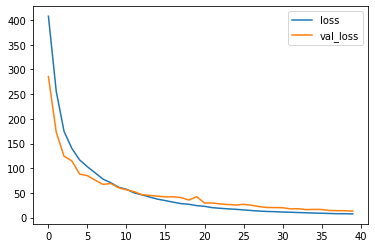

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### Look at the predicted mean of the CPD on the testset


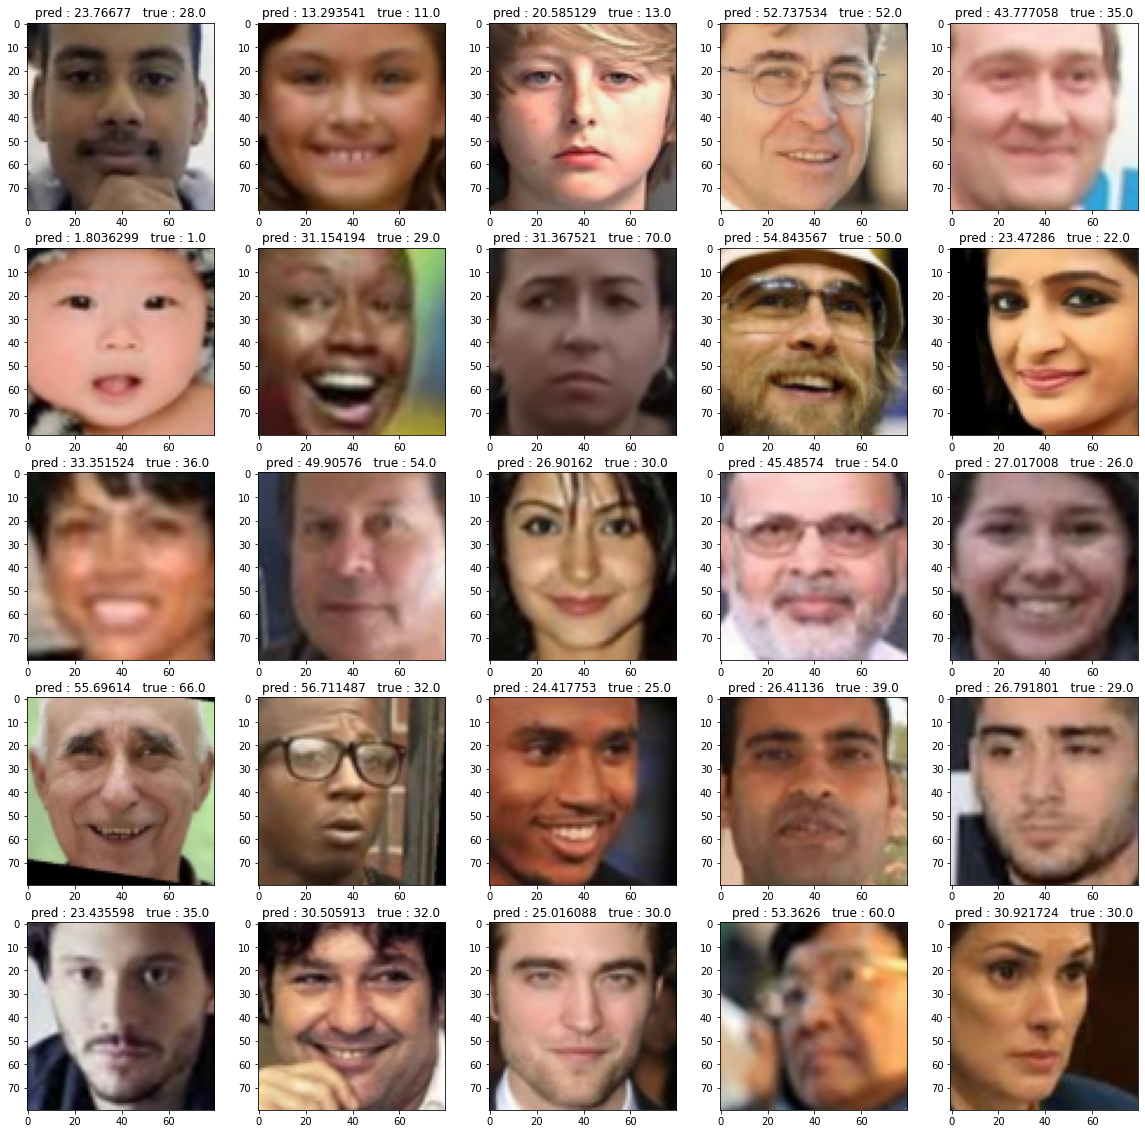

In [0]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title("pred : "+ np.str(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)])[0][0]) + "   true : "+ np.str(y_test[i]))

#### Look at the predicted mean and the predicted sigma of the CPD on the testset


[[23.76677]]
[[2.0873456]]


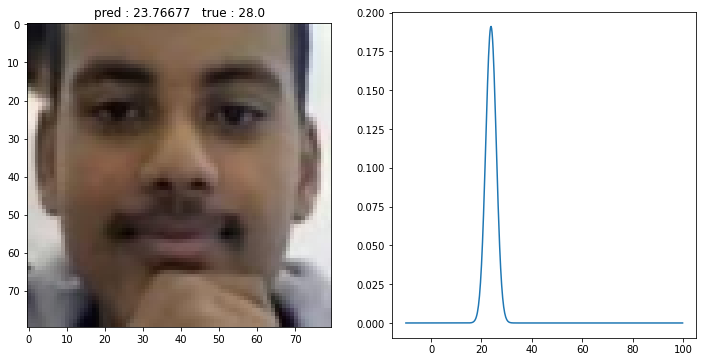

[[13.293541]]
[[2.0873456]]


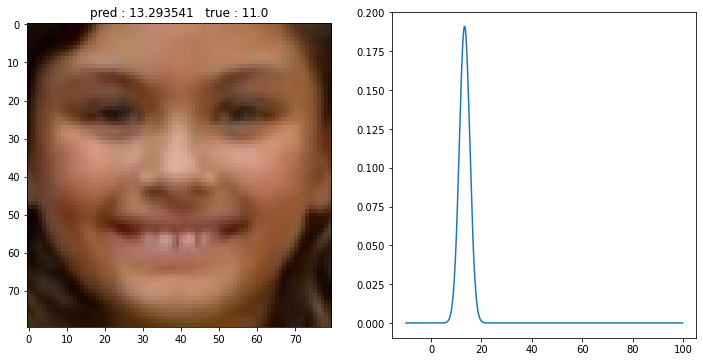

[[20.585129]]
[[2.0873456]]


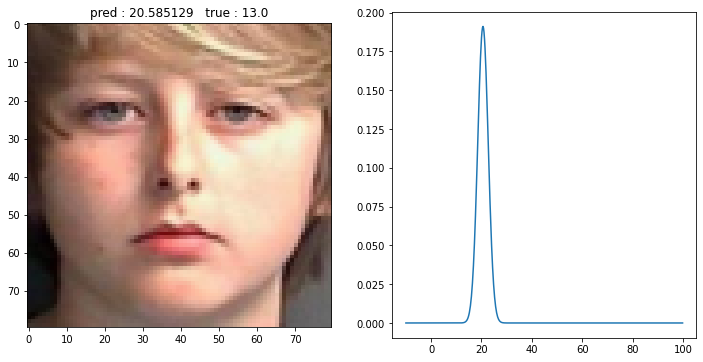

[[52.737534]]
[[2.0873456]]


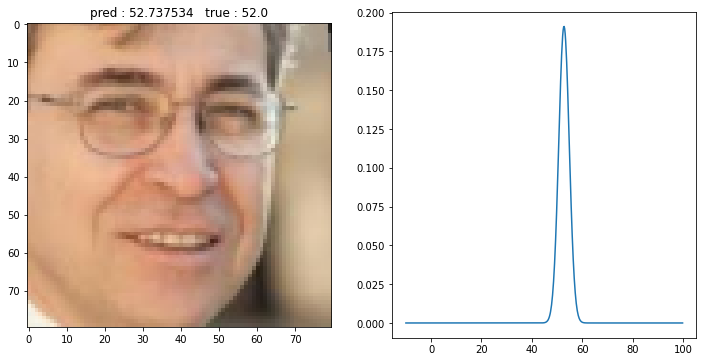

[[43.777058]]
[[2.0873456]]


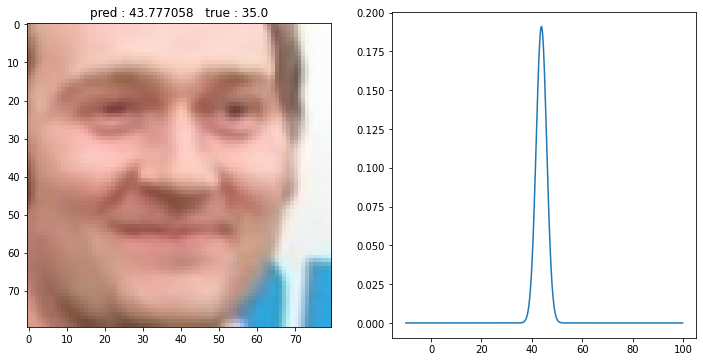

[[1.8036299]]
[[2.0873456]]


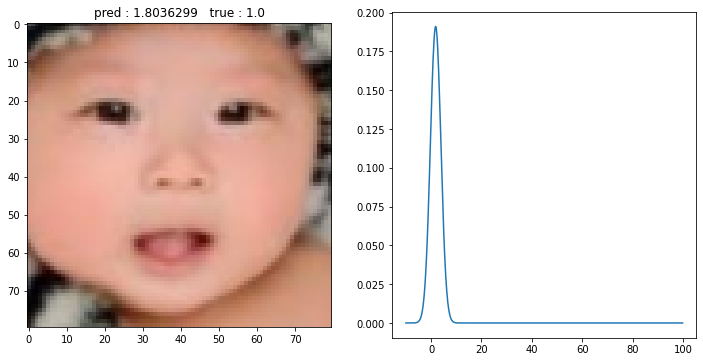

[[31.154194]]
[[2.0873456]]


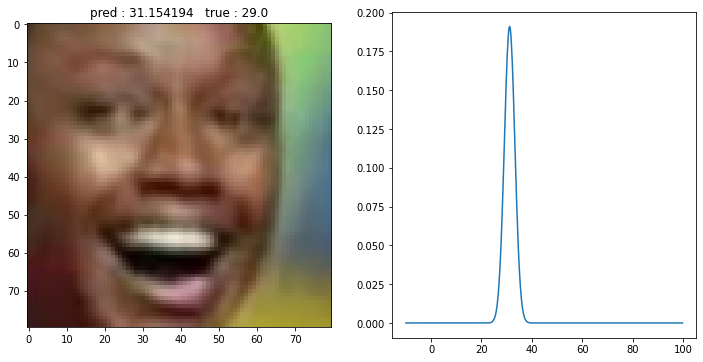

[[31.367521]]
[[2.0873456]]


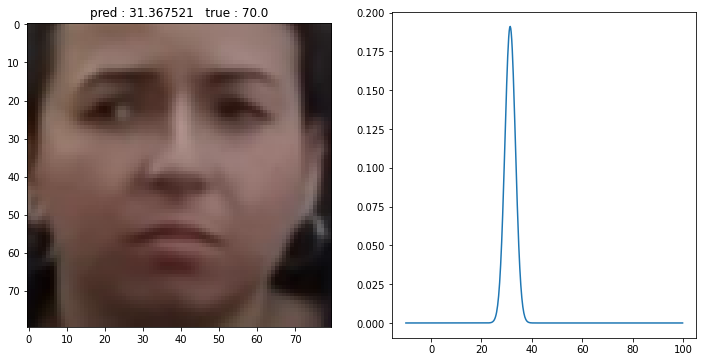

[[54.843567]]
[[2.0873456]]


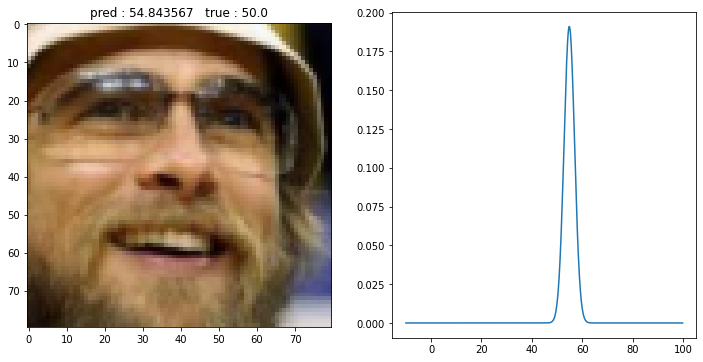

[[23.47286]]
[[2.0873456]]


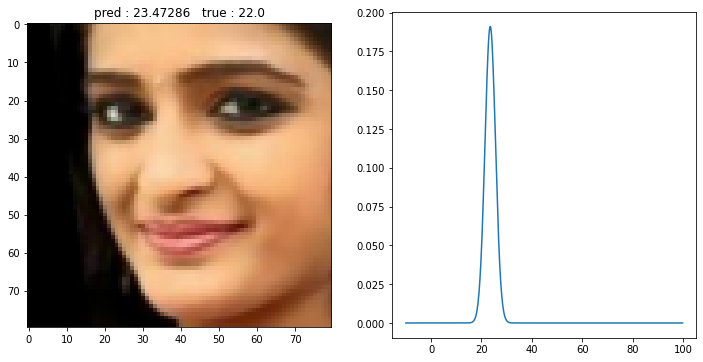

In [0]:
for i in range(0,10):
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.imshow(X_test[i])
  plt.title("pred : "+ np.str(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)])[0][0]) + "   true : "+ np.str(y_test[i]))
  print(model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))
  print(model_const_sd_sd.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))
  d = tfd.Normal(loc=model_const_sd_mean.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]), scale=model_const_sd_sd.predict([X_test[i:i+1],np.expand_dims(np.ones(len(X_test[i:i+1])),1)]))           #A
  plt.subplot(1,2,2)
  plt.plot(np.arange(-10,100,0.2),d.prob(np.arange(-10,100,0.2))[0])
  plt.show()

## Fit a regression model with felxible variance
In the next cells you will afain define and fit a model on the face images. You will use a CNN to model the mu parameter of a gaussian conditional probability distribution, but this time the sigma will not be constant for all inputs. Every iamge will be able to have a different sigma. For the loss we use the NLL.

In [0]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(80,80,3))
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(inputs)
x = Convolution2D(16,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = Convolution2D(32,kernel_size,padding='same',activation="relu")(x)
x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dense(500,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(2)(x)
dist = tfp.layers.DistributionLambda(my_dist)(x) 

model_flex = Model(inputs=inputs, outputs=dist)
model_flex.compile(tf.keras.optimizers.Adam(), loss=NLL) 


In [0]:
# train the model
history=model_flex.fit(X_train, np.array(y_train,dtype="float32"), 
                  batch_size=16, 
                  epochs=40,
                  verbose=1, 
                  validation_data=(X_val, np.array(y_val,dtype="float32")))


Train on 10642 samples, validate on 5242 samples
Epoch 1/40
10642/10642 [==============================] - 6s 544us/sample - loss: 18.4111 - val_loss: 4.5330
Epoch 2/40
10642/10642 [==============================] - 5s 471us/sample - loss: 4.8714 - val_loss: 4.4699
Epoch 3/40
10642/10642 [==============================] - 5s 470us/sample - loss: 4.6083 - val_loss: 4.4753
Epoch 4/40
10642/10642 [==============================] - 5s 465us/sample - loss: 4.5414 - val_loss: 4.4188
Epoch 5/40
10642/10642 [==============================] - 5s 467us/sample - loss: 4.5568 - val_loss: 4.4787
Epoch 6/40
10642/10642 [==============================] - 5s 473us/sample - loss: 4.4901 - val_loss: 4.4450
Epoch 7/40
10642/10642 [==============================] - 5s 474us/sample - loss: 4.4972 - val_loss: 4.3337
Epoch 8/40
10642/10642 [==============================] - 5s 472us/sample - loss: 4.4106 - val_loss: 4.4611
Epoch 9/40
10642/10642 [==============================] - 5s 476us/sample - loss: 4.31

In [0]:
model_mean = Model(inputs=inputs, outputs=dist.mean())
model_sd = Model(inputs=inputs, outputs=dist.stddev())

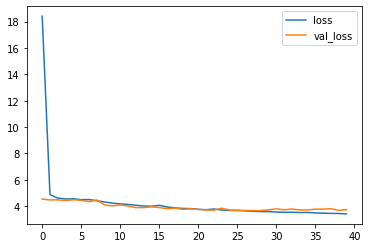

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### Look at the predicted mean of the CPD on the testset


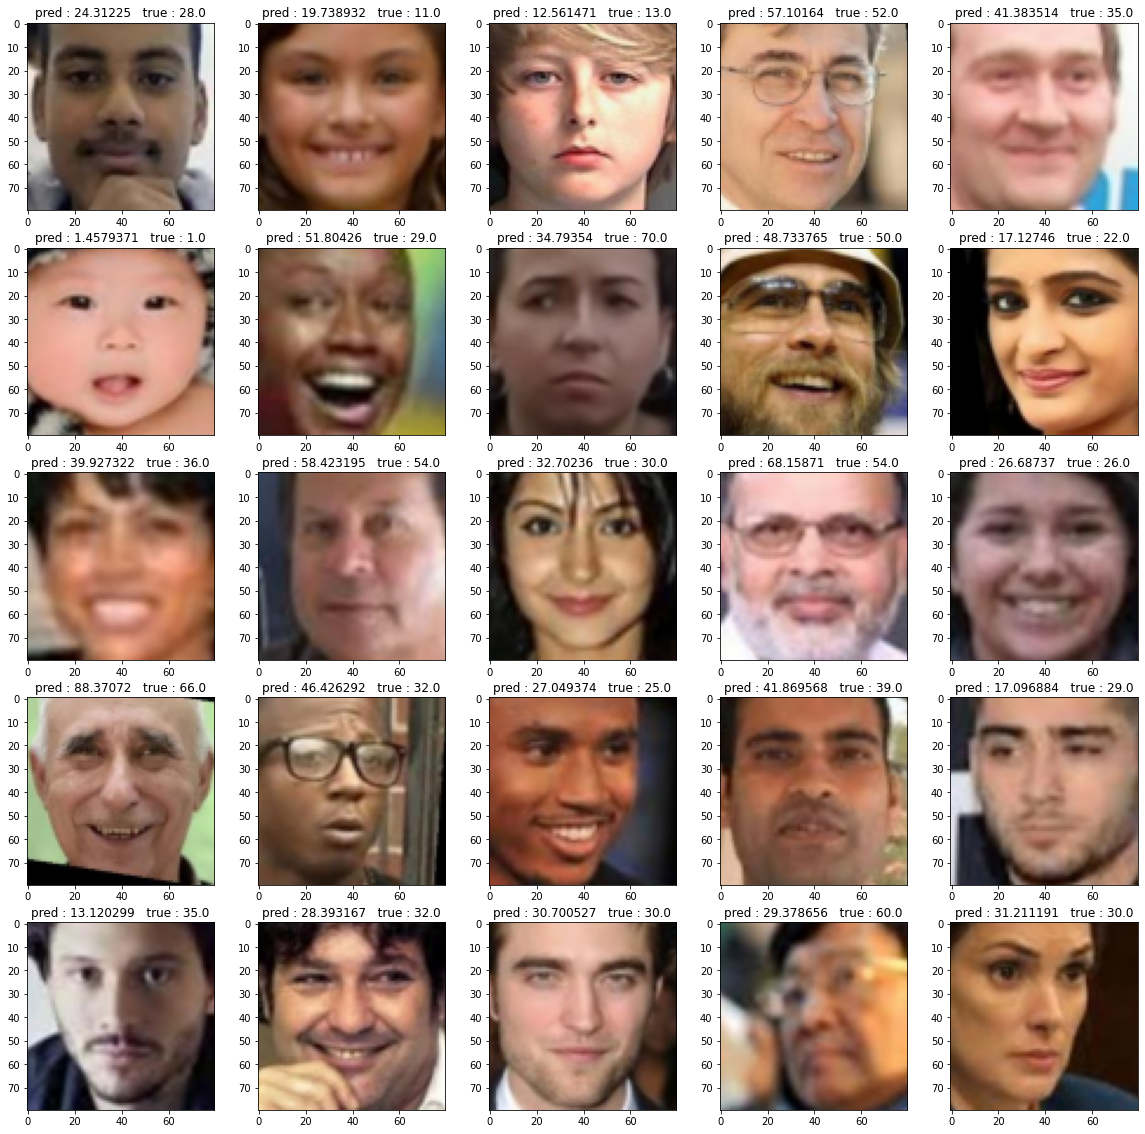

In [0]:
plt.figure(figsize=(20,20))
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title("pred : "+ np.str(model_mean.predict(X_test[i:i+1])[0][0]) + "   true : "+ np.str(y_test[i]))

#### Look at the predicted mean and the predicted sigma of the CPD on the testset


[[24.31225]]
[[7.016934]]


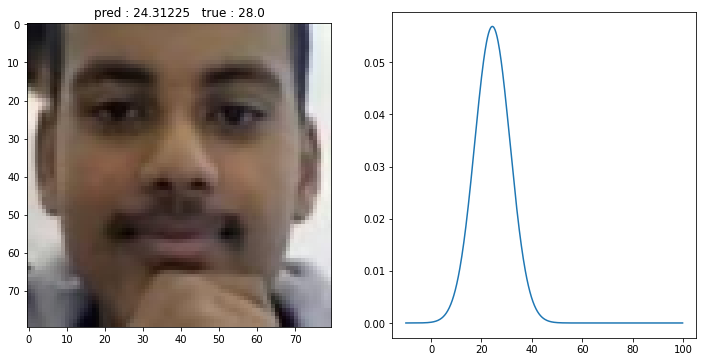

[[19.738932]]
[[6.8576946]]


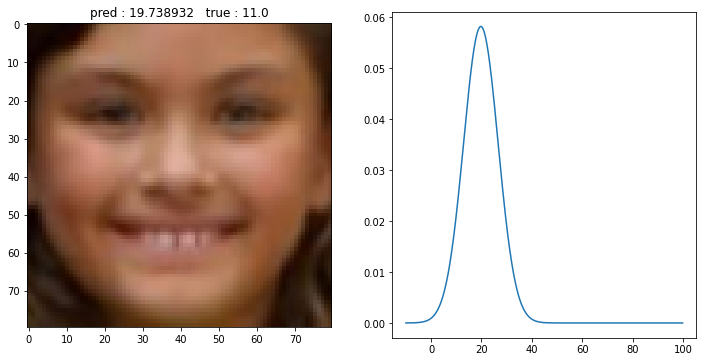

[[12.561471]]
[[6.0484443]]


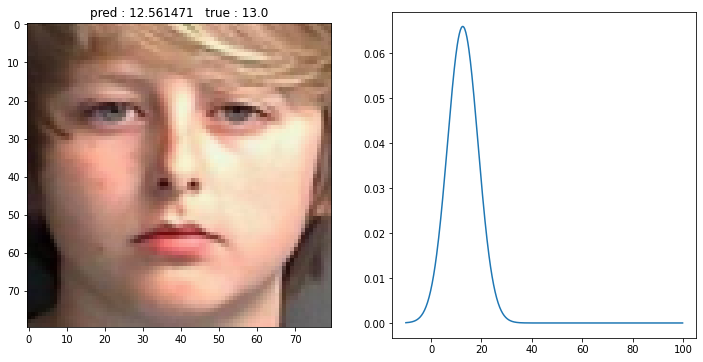

[[57.10164]]
[[15.955895]]


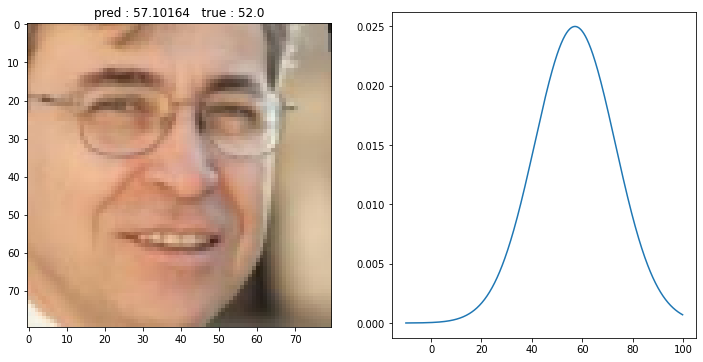

[[41.383514]]
[[11.391197]]


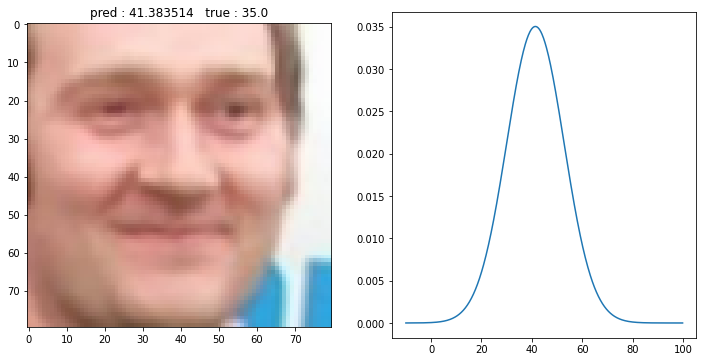

[[1.4579371]]
[[0.61716217]]


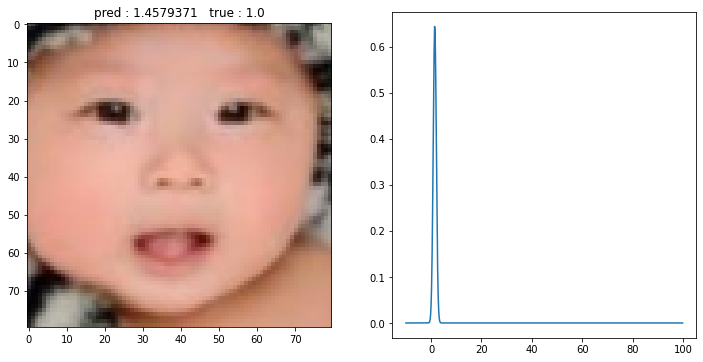

[[51.80426]]
[[14.809159]]


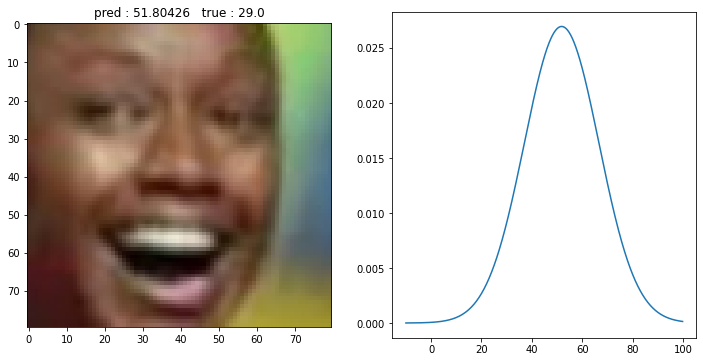

[[34.79354]]
[[10.3828745]]


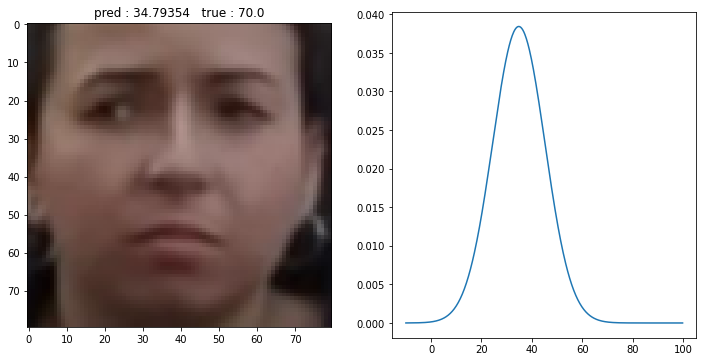

[[48.733765]]
[[14.411442]]


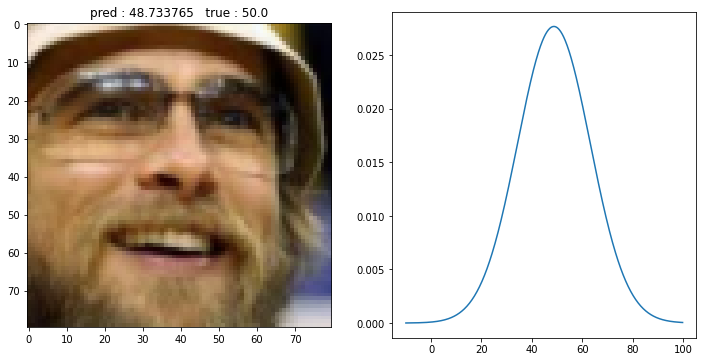

[[17.12746]]
[[4.8063436]]


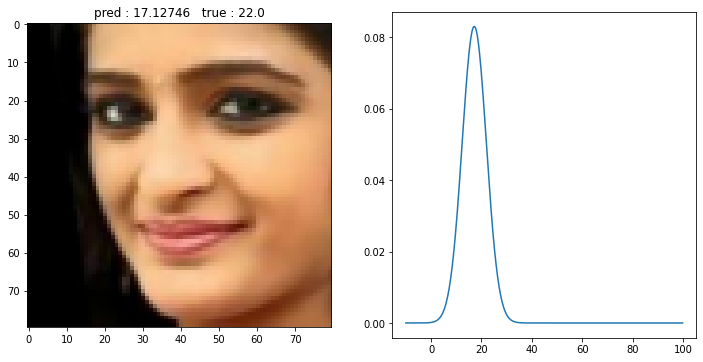

In [0]:
for i in range(0,10):
  plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.imshow(X_test[i])
  plt.title("pred : "+ np.str(model_mean.predict(X_test[i:i+1])[0][0]) + "   true : "+ np.str(y_test[i]))
  print(model_mean.predict(X_test[i:i+1]))
  print(model_sd.predict(X_test[i:i+1]))
  d = tfd.Normal(loc=model_mean.predict(X_test[i:i+1]), scale=model_sd.predict(X_test[i:i+1]))           #A
  plt.subplot(1,2,2)
  plt.plot(np.arange(-10,100,0.2),d.prob(np.arange(-10,100,0.2))[0])
  plt.show()

#### Exercise
Calculate the MSE the RMSE and the NLL for both models on the testset.  
Which model would you prefer in practice and why?  



In [0]:
mse_1=np.average(np.square(model_const_sd_mean.predict([X_test,np.expand_dims(np.ones(len(X_test)),1)]).flatten()-y_test))
rmse_1=np.sqrt(mse_1)
nll_1=model_const_sd.evaluate([X_test,np.expand_dims(np.ones(len(X_test)),1)],y_test,verbose=0)

mse_2=np.average(np.square(model_mean.predict(X_test).flatten()-y_test))
rmse_2=np.sqrt(mse_2)
nll_2=model_flex.evaluate(X_test,y_test,verbose=0)



In [0]:
import pandas as pd
df1= pd.DataFrame(
         { 'MSE' : mse_1, 'RMSE' : rmse_1, 'nll ' : nll_1}, index=['model const sigma'])
df2= pd.DataFrame(
         { 'MSE' : mse_2, 'RMSE' : rmse_2, 'nll ' : nll_2}, index=['model flex sigma'])
pd.concat([df1,df2])


MSE       RMSE       nll 
model const sigma  101.438934  10.071690  13.295717
model flex sigma   126.023178  11.226005   3.872254